**Preparation and necessary tools**

In [1]:
from Lyapunov import *
from dynamics_toolkit import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from tqdm import tqdm
from torch.autograd.functional import jacobian
from torch import tensor, dot, matmul, transpose, stack
from scipy.linalg import block_diag, circulant
from scipy.stats import dirichlet, multivariate_normal
from itertools import product, combinations

# Test
We test some of the functions in the `Lyapunov` module for the computation of Lyapunov exponents in latter section.

$$\dot{x} = x_i ((Ax)_i - x^\top Ax)$$

## Numerical computation of the Jacobian
We use `Pytorch` to compute Jacobian using automatic differentiation. We test the function with the standard quadratic $f(x) = x^\top Ax$, which has Jacobian $Df(x) = (A+A^\top)x$.

In [82]:
A = tensor(np.random.rand(3,3))
f = lambda x: dot(x,matmul(A,x))
x = np.random.rand(3)
 
#Printing the Jacobian
Jf = compute_Jacobian(f)
print(Jf(x))
print(np.array(matmul((A + transpose(A,0,1)), tensor(x))))

[2.28098465 1.43588776 2.1501847 ]
[2.28098465 1.43588776 2.1501847 ]


## Computation of Lyapunov Exponents

We obtain the (finite-time) Lyapnunov spectrum by solving the first variational function. This is implemented by the `Lyapunov` function in the `Lyapunov` module. We test it against several standard differential equations.

**Test:** For linear system, Lyapunov exponents are equal to eigenvalues of matrix.

In [259]:
A = np.diag([0.1,-0.1,-0.5])
f = lambda x: matmul(tensor(A),x)
x_int = [0.1,0.1,0.1]

In [260]:
Lambda, x_arr = Lyapunov(f, x_int, interval=0.01, step=3000, show_x=True)

100%|██████████| 3000/3000 [00:22<00:00, 132.88it/s]


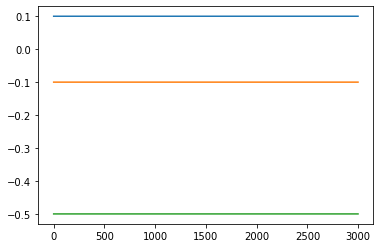

In [261]:
plt.plot(Lambda)

**Test:** We test our implementation against Lorenz attractor, which is known to have the maximum Lyapunov exponent of around 0.9056. [1].

[1] Viswanath, Divakar. Lyapunov exponents from random Fibonacci sequences to the Lorenz equations. Doctoral dissertation. Cornell University, 1998.

In [2]:
def Lorenz(x):
    return (10*(x[1]-x[0]), x[0]*(28-x[2])-x[1], x[0]*x[1]-(8/3)*x[2])

def Lorenz_Jacobian(x):
    return stack(jacobian(Lorenz, tensor(x))).numpy()

In [3]:
Lambda = Lyapunov(Lorenz, [0.5,0.5,0.5], 
                         interval=0.02, step=10000, 
                         physical_jacobian=Lorenz_Jacobian, physical_tensor_to_numpy = False,
                         show_x = False)

100%|██████████| 10000/10000 [12:28<00:00, 13.36it/s]


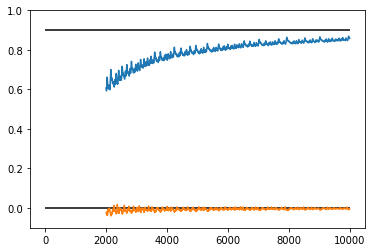

In [4]:
plt.plot(np.arange(2000,10000), Lambda[2000:])
plt.ylim([-0.1,1.0])
plt.hlines([0,0.9], 0, 10000)

# Experiment: Hypercycle with $n=5$.

**Preliminary Examples.**

In [9]:
def replicator(x):
    return x * (matmul(tensor(A).double(), x) - dot(x,matmul(tensor(A).double(),x)))

def replicator_numpy(x):
    numpy_func = tensor_to_numpy(replicator)
    return numpy_func(x)

In [8]:
A = circulant([0, 1, 0, 0, 0])
my_replicator = oneD_replicator(A)
x_int = np.array([0.98,0.005,0.005,0.005,0.005])
Lambdac, x_arrc = Lyapunov(my_replicator.replicator_tensor, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [13:26<00:00, 24.79it/s]


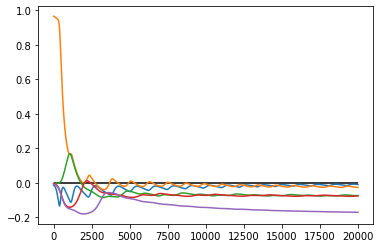

In [10]:
plt.plot(Lambdac)
plt.hlines([0], xmin=0, xmax=20000)

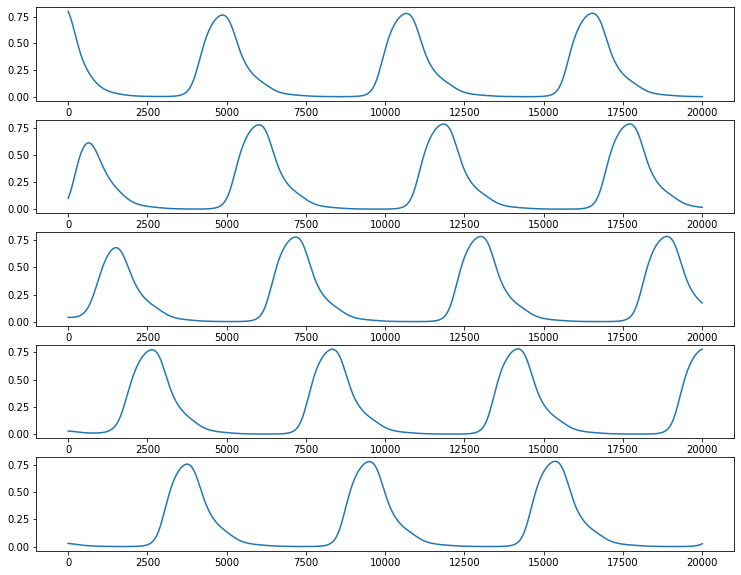

In [40]:
fig, ax = plt.subplots(5,1,figsize=(12.5,10))
for i in range(5):
    ax[i].plot(x_arr[:,i])

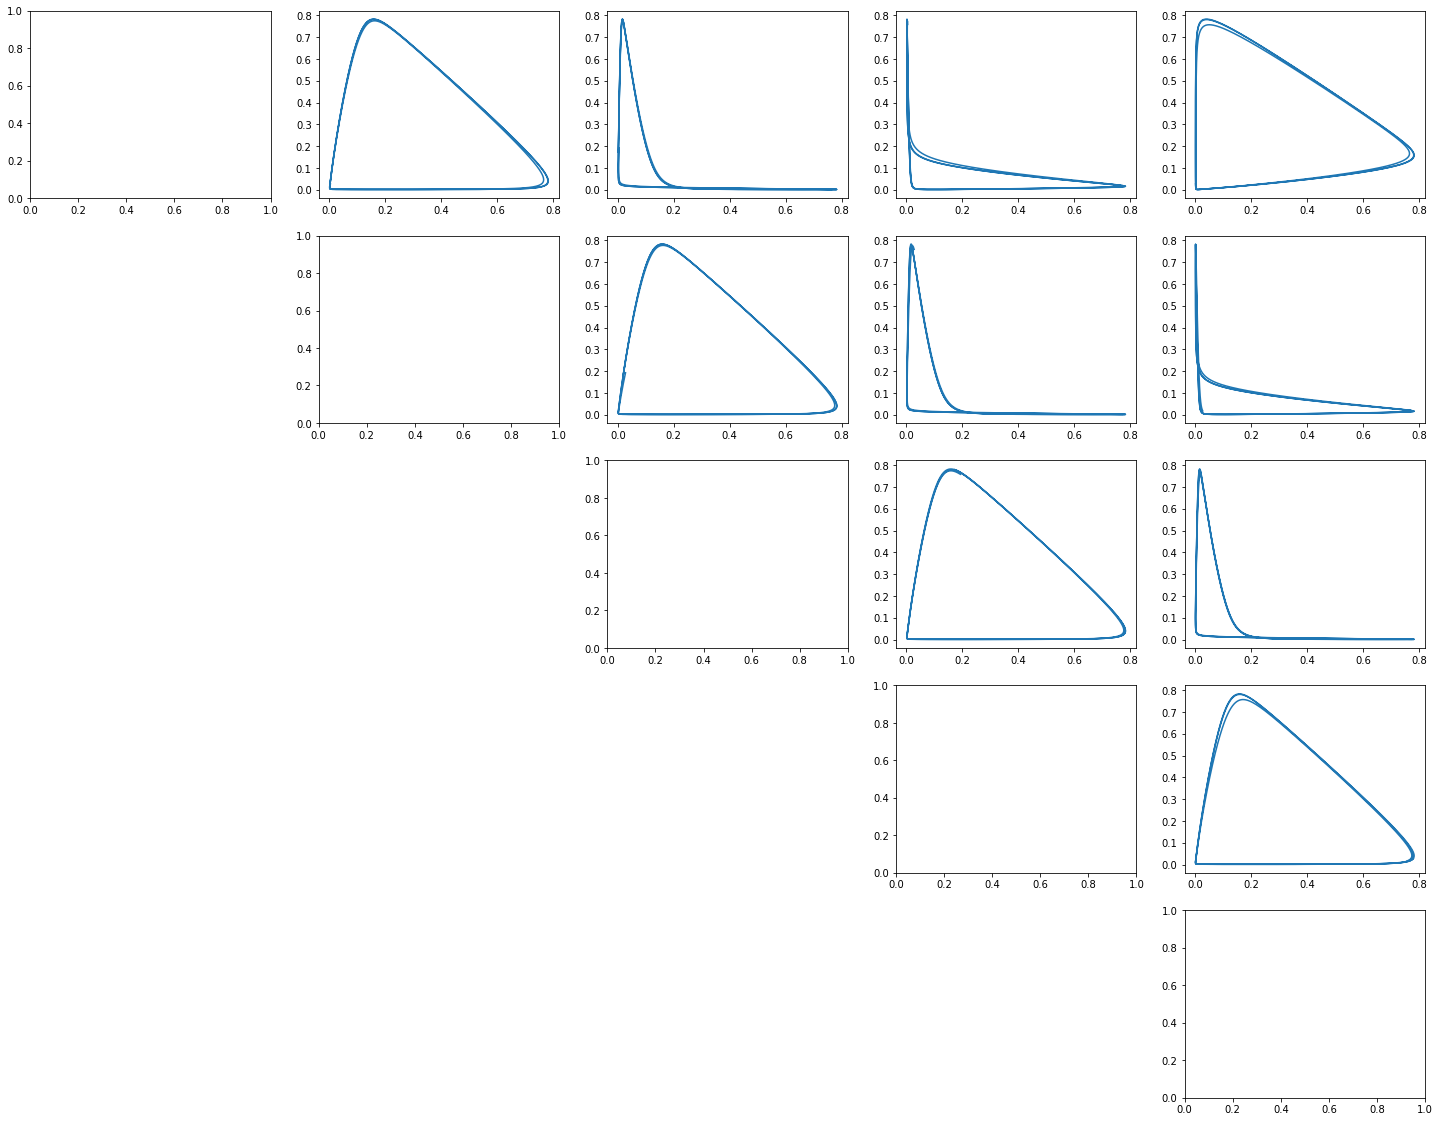

In [85]:
fig, ax = plt.subplots(5,5,figsize=(25,20))
for i,j in combinations(range(5), 2):
    ax[i][j].plot(x_arr[2500:,i], x_arr[2500:,j])
    ax[j][i].axis("off")

Text(0.5, 0, 'y5')

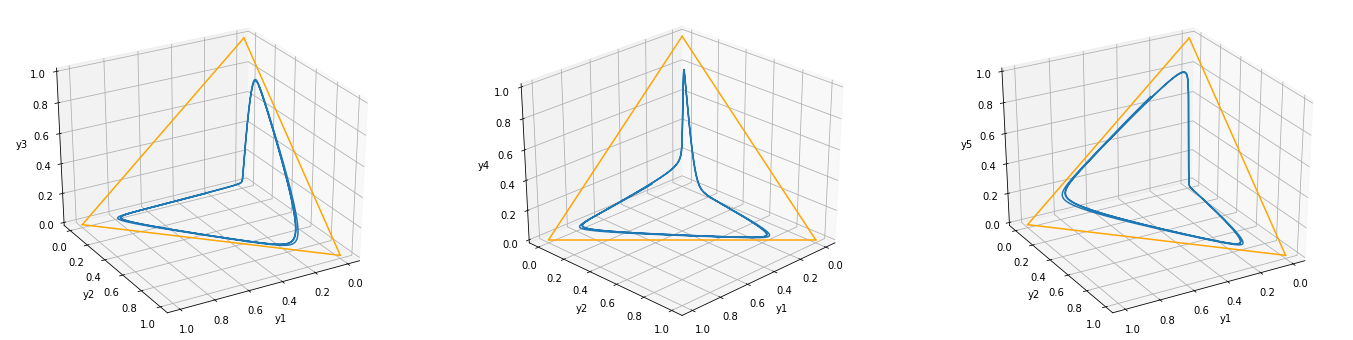

In [143]:
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(1,3,1, projection="3d")
ax.plot3D(x_arr[5000:,0], x_arr[5000:,1], x_arr[5000:,2])
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y3")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.plot3D(x_arr[5000:,0], x_arr[5000:,1], x_arr[5000:,3])
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=45)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y4")

ax = fig.add_subplot(1,3,3, projection="3d")
# ax.plot3D(x_arr[:,2], x_arr[:,3], x_arr[:,5])
ax.plot3D(x_arr[5000:,0], x_arr[5000:,1], x_arr[5000:,4])
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y5")

Toolbox: Simulating points (uniformly) on the simplex (using Dirichlet distribution).

In [92]:
alpha = np.ones(5)
dirichlet.rvs(alpha)

array([[0.10456911, 0.30823176, 0.12592496, 0.04053199, 0.42074218]])

Some are positive, some are negative.

**DONE: Example - Initial condition close to boundary but not at vertices**

In [139]:
A = circulant([0, 1, 0, 0, 0])
x_int = np.array([0.457,0.457,0.002,0.002,0.002])
Lambda, x_arr = Lyapunov(replicator, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [13:47<00:00, 24.16it/s]


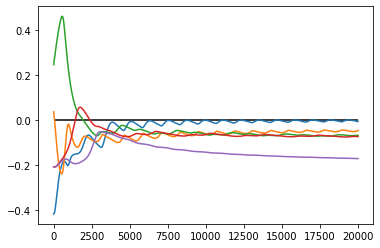

In [140]:
plt.plot(Lambda)
plt.hlines([0], xmin=0, xmax=20000)

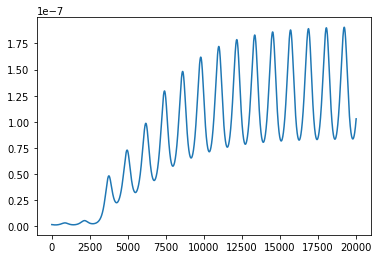

In [120]:
P_arr = x_arr[:,0] * x_arr[:,1] * x_arr[:,2] * x_arr[:,3] * x_arr[:,4]
plt.plot(P_arr)

Text(602.1720588235295, 0.5, 'y')

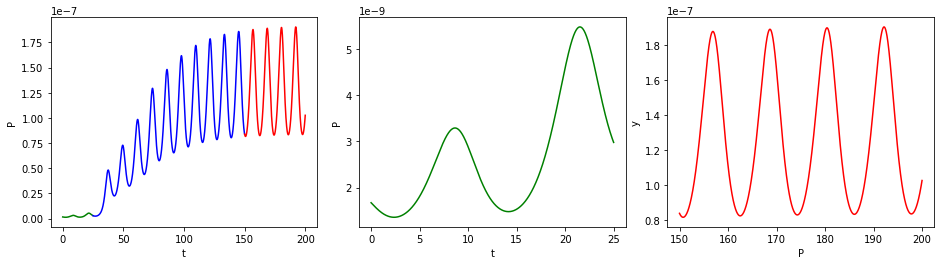

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13,3.5))
plt.tight_layout()

ax[0].plot(0.01*np.arange(2500), P_arr[:2500], color="green")
ax[0].plot(0.01*np.arange(2500,15000),P_arr[2500:15000], color="blue")
ax[0].plot(0.01*np.arange(15000,20000),P_arr[15000:20000], color="red")
ax[0].set_xlabel("t")
ax[0].set_ylabel("P")

ax[1].plot(0.01*np.arange(2500), P_arr[:2500], color="green")
ax[1].set_xlabel("t")
ax[1].set_ylabel("P")

ax[2].plot(0.01*np.arange(15000,20000),P_arr[15000:20000], color="red")
ax[2].set_xlabel("P")
ax[2].set_ylabel("y")

Generation of Figure 4

Text(0.5, 0, 'y5')

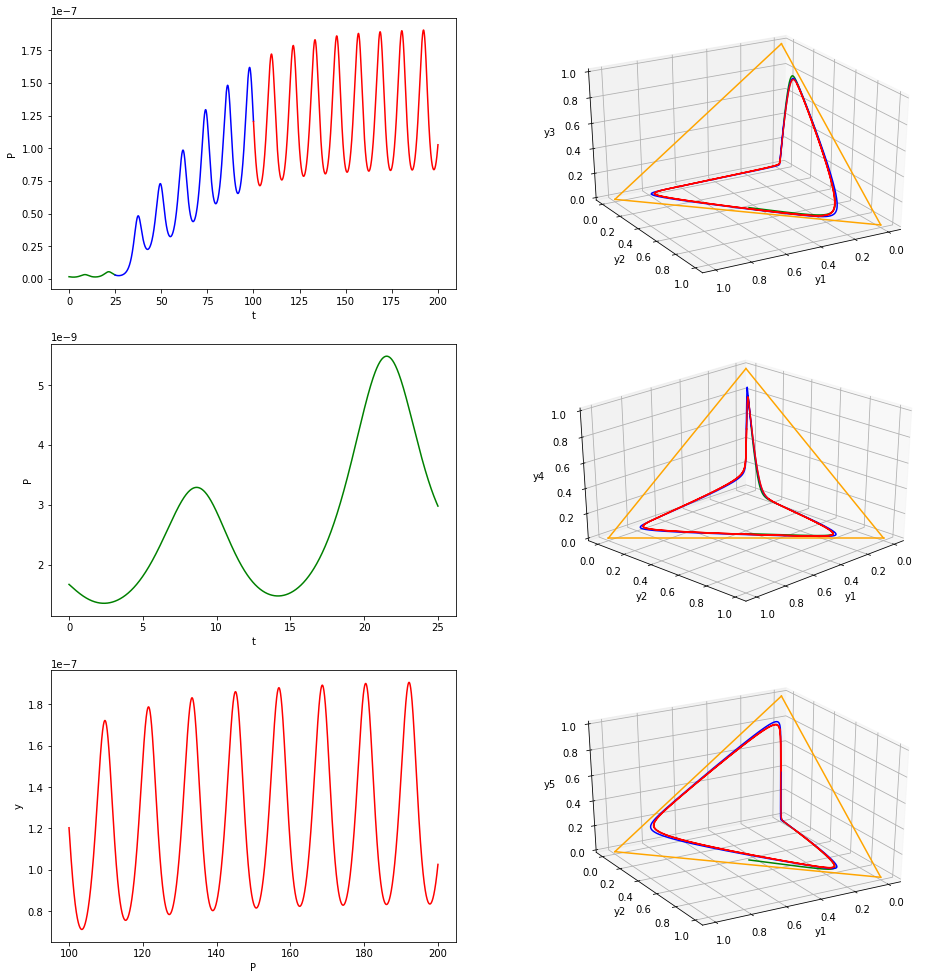

In [156]:
fig = plt.figure(figsize=(16,17))
plt.tight_layout()

ax = fig.add_subplot(3,2,1)
ax.plot(0.01*np.arange(2500), P_arr[:2500], color="green")
ax.plot(0.01*np.arange(2500,10000),P_arr[2500:10000], color="blue")
ax.plot(0.01*np.arange(10000,20000),P_arr[10000:20000], color="red")
ax.set_xlabel("t")
ax.set_ylabel("P")

ax = fig.add_subplot(3,2,3)
ax.plot(0.01*np.arange(2500), P_arr[:2500], color="green")
ax.set_xlabel("t")
ax.set_ylabel("P")

ax = fig.add_subplot(3,2,5)
ax.plot(0.01*np.arange(10000,20000),P_arr[10000:20000], color="red")
ax.set_xlabel("P")
ax.set_ylabel("y")

ax = fig.add_subplot(3,2,2, projection="3d")
ax.plot3D(x_arr[0:2500,0], x_arr[0:2500,1], x_arr[0:2500,2], color="green")
ax.plot3D(x_arr[2500:10000,0], x_arr[2500:10000,1], x_arr[2500:10000,2], color="blue")
ax.plot3D(x_arr[10000:20000:,0], x_arr[10000:20000:,1], x_arr[10000:20000:,2], color="red")
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y3")

ax = fig.add_subplot(3,2,4, projection="3d")
ax.plot3D(x_arr[0:2500,0], x_arr[0:2500,1], x_arr[0:2500,3], color="green")
ax.plot3D(x_arr[2500:10000,0], x_arr[2500:10000,1], x_arr[2500:10000,3], color="blue")
ax.plot3D(x_arr[10000:20000:,0], x_arr[10000:20000:,1], x_arr[10000:20000:,3], color="red")
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=45)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y4")

ax = fig.add_subplot(3,2,6, projection="3d")
# ax.plot3D(x_arr[:,2], x_arr[:,3], x_arr[:,5])
ax.plot3D(x_arr[0:2500,0], x_arr[0:2500,1], x_arr[0:2500,4], color="green")
ax.plot3D(x_arr[2500:10000,0], x_arr[2500:10000,1], x_arr[2500:10000,4], color="blue")
ax.plot3D(x_arr[10000:20000:,0], x_arr[10000:20000:,1], x_arr[10000:20000:,4], color="red")
ax.plot3D([1,0],[0,1],[0,0], color="orange")
ax.plot3D([1,0],[0,0],[0,1], color="orange")
ax.plot3D([0,0],[1,0],[0,1], color="orange")
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y5")
# plt.savefig("Example_boundary_non_vertices")

**Sensitivity of initial condition near saddle point.**

Set error approximately 0.02 (10% of 0.2) to decrease time we need to see Lyapunov exponent decrease to zero.

In [117]:
A = circulant([0, 1, 0, 0, 0])
x_int = simulate_close(x_equi, 0.1, state=0) # use simulate_close? for documentation.
Lambda0, x_arr0 = Lyapunov(replicator, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [11:53<00:00, 28.03it/s]


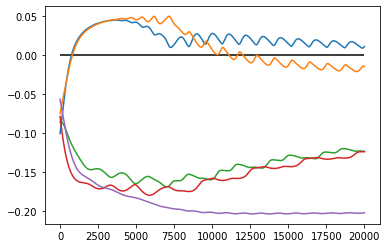

In [118]:
plt.plot(Lambda0)
plt.hlines([0], xmin=0, xmax=20000)

In [110]:
A = circulant([0, 1, 0, 0, 0])
x_int = simulate_close(x_equi, 0.01, state=0)
Lambda1, x_arr1 = Lyapunov(replicator, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [11:43<00:00, 28.41it/s]


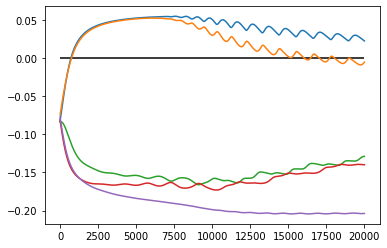

In [111]:
plt.plot(Lambda1)
plt.hlines([0], xmin=0, xmax=20000)

In [112]:
A = circulant([0, 1, 0, 0, 0])
x_int = simulate_close(x_equi, 0.001, state=0)
Lambda2, x_arr2 = Lyapunov(replicator, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [11:38<00:00, 28.65it/s]


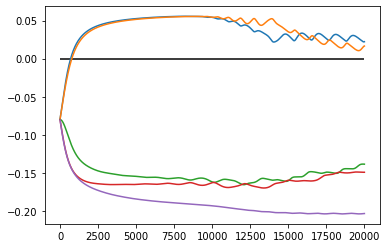

In [113]:
plt.plot(Lambda2)
plt.hlines([0], xmin=0, xmax=20000)

Set error approximately to 0.0001 to better illustrate sensitivity of condition.

In [114]:
A = circulant([0, 1, 0, 0, 0])
x_int = simulate_close(x_equi, 0.0001, state=0)
Lambda3, x_arr3 = Lyapunov(replicator, x_int, interval=0.01, step=20000, show_x=True)

100%|██████████| 20000/20000 [11:58<00:00, 27.82it/s]


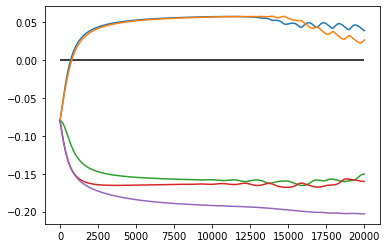

In [115]:
plt.plot(Lambda3)
plt.hlines([0], xmin=0, xmax=20000)

Trying out initial condition with various distance to the centroid (Figure 9)

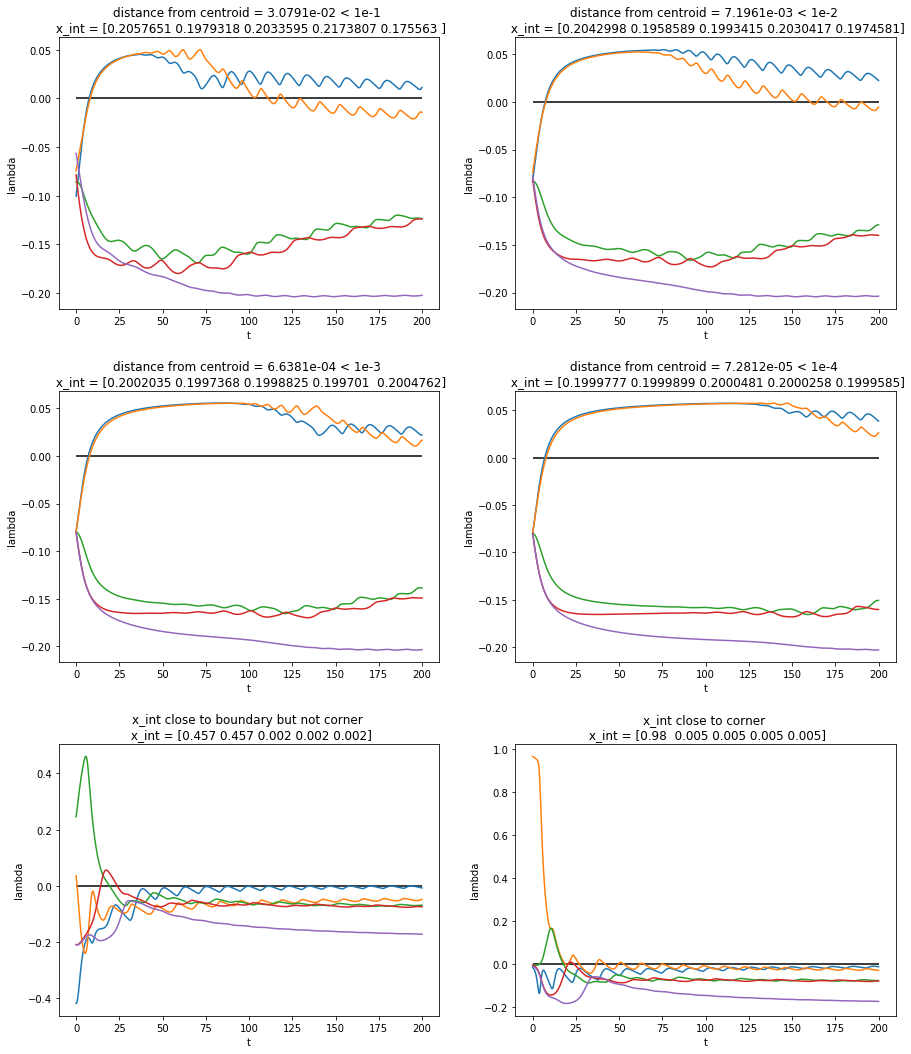

In [163]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,18))

ax[0,0].plot(np.linspace(0,200,20000),Lambda0)
ax[0,0].set_title(f"distance from centroid = {np.linalg.norm(x_equi-x_arr0[0,0:5]):.4e} < 1e-1 \n x_int = {np.around(x_arr0[0,0:5],7)}")
ax[0,0].hlines([0], xmin=0, xmax=200)
ax[0,0].set_ylabel("lambda")
ax[0,0].set_xlabel("t")

ax[0,1].plot(np.linspace(0,200,20000),Lambda1)
ax[0,1].hlines([0], xmin=0, xmax=200)
ax[0,1].set_title(f"distance from centroid = {np.linalg.norm(x_equi-x_arr1[0,0:5]):.4e} < 1e-2 \n x_int = {np.around(x_arr1[0,0:5],7)}")
ax[0,1].set_ylabel("lambda")
ax[0,1].set_xlabel("t")

ax[1,0].plot(np.linspace(0,200,20000),Lambda2)
ax[1,0].set_title(f"distance from centroid = {np.linalg.norm(x_equi-x_arr2[0,0:5]):.4e} < 1e-3 \n x_int = {np.around(x_arr2[0,0:5],7)}")
ax[1,0].hlines([0], xmin=0, xmax=200)
ax[1,0].set_ylabel("lambda")
ax[1,0].set_xlabel("t")

ax[1,1].plot(np.linspace(0,200,20000),Lambda3)
ax[1,1].set_title(f"distance from centroid = {np.linalg.norm(x_equi-x_arr3[0,0:5]):.4e} < 1e-4 \n x_int = {np.around(x_arr3[0,0:5],7)}")
ax[1,1].hlines([0], xmin=0, xmax=200)
ax[1,1].set_ylabel("lambda")
ax[1,1].set_xlabel("t")

ax[2,0].plot(np.linspace(0,200,20000),Lambda)
ax[2,0].set_title(f"x_int close to boundary but not corner \n x_int = {np.around(x_arr[0,0:5],3)}")
ax[2,0].hlines([0], xmin=0, xmax=200)
ax[2,0].set_ylabel("lambda")
ax[2,0].set_xlabel("t")

ax[2,1].plot(np.linspace(0,200,20000),Lambdac)
ax[2,1].set_title(f"x_int close to corner \n x_int = {np.around(x_arrc[0,0:5],3)}")
ax[2,1].hlines([0], xmin=0, xmax=200)
ax[2,1].set_ylabel("lambda")
ax[2,1].set_xlabel("t")

fig.subplots_adjust(hspace=0.3)

plt.savefig("Hypercycle_Lyapunov")

Demonstrate using two orbits (Figure 6)

In [236]:
# compute orbits
ts = np.linspace(0,1000,100001)
x_equi = np.ones(5)/5
x_int1 = simulate_close(x_equi, 0.0001, state=0)
x_int2 = simulate_close(x_equi, 0.0001, state=1234)
x_int_diff = np.linalg.norm(x_int2 - x_int1)
print(x_int_diff)
xt1 = odeint(lambda y,t: replicator_numpy(y), x_int1, ts)
xt2 = odeint(lambda y,t: replicator_numpy(y), x_int2, ts)

5.201677772005931e-05


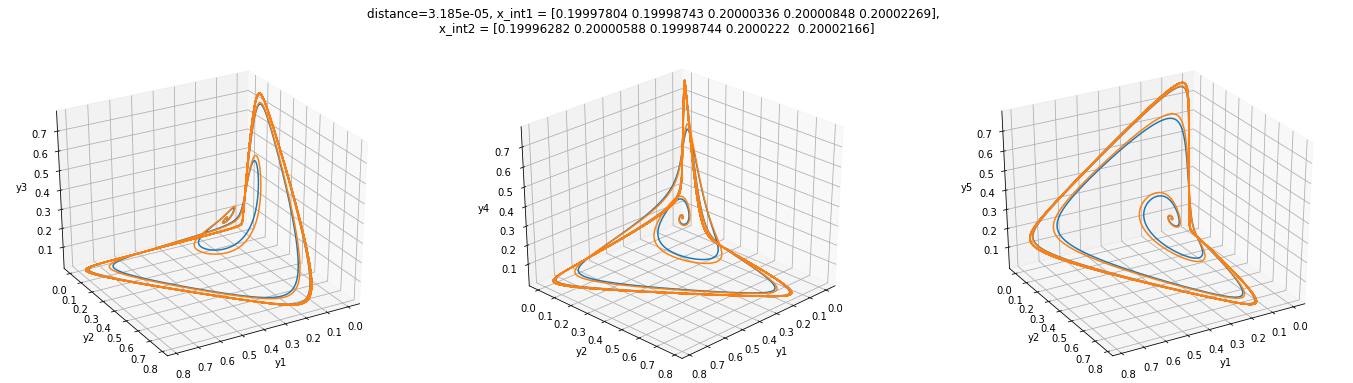

In [189]:
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(1,3,1, projection="3d")
ax.plot3D(xt1[:,0], xt1[:,1], xt1[:,2])
ax.plot3D(xt2[:,0], xt2[:,1], xt2[:,2])
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y3")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.plot3D(xt1[:,0], xt1[:,1], xt1[:,3])
ax.plot3D(xt2[:,0], xt2[:,1], xt2[:,3])
ax.view_init(azim=45)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y4")

ax = fig.add_subplot(1,3,3, projection="3d")
ax.plot3D(xt1[:,0], xt1[:,1], xt1[:,4])
ax.plot3D(xt2[:,0], xt2[:,1], xt2[:,4])
ax.view_init(azim=60)
ax.set_xlabel("y1")
ax.set_ylabel("y2")
ax.set_zlabel("y5")

fig.suptitle(f'distance={np.linalg.norm(x_int1-x_int2):.3e}, x_int1 = {x_int1}, \n x_int2 = {x_int2}')
plt.savefig("Hypercycle_example_sensitive_init")

Figure 8

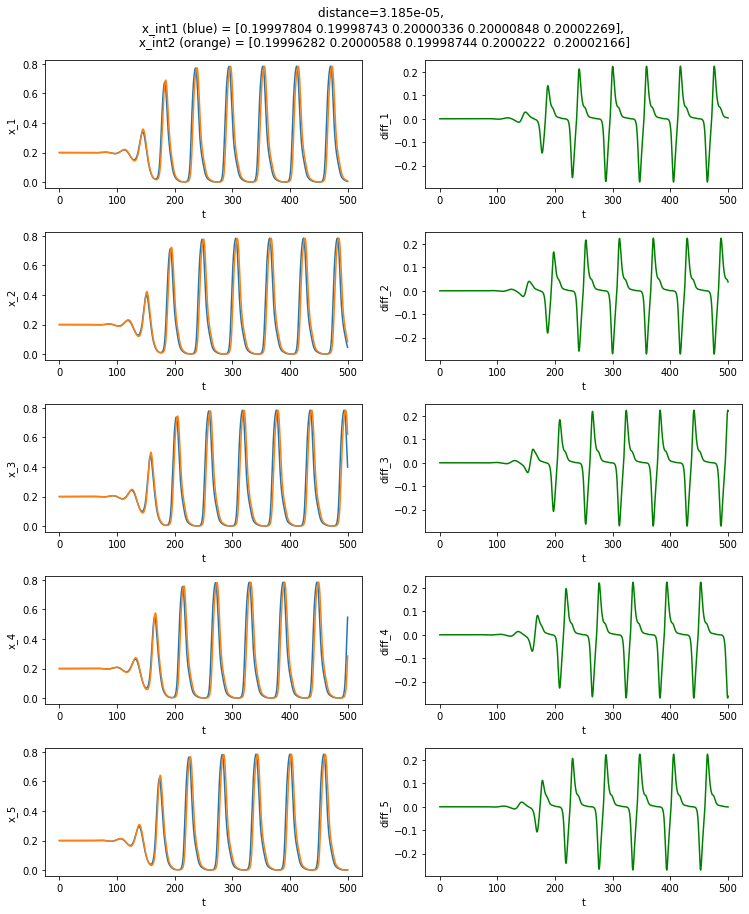

In [214]:
fig, ax = plt.subplots(5,2,figsize=(12.5,15))
for i in range(5):
    ax[i,0].plot(np.linspace(0,500,50001), xt1[:,i])
    ax[i,0].plot(np.linspace(0,500,50001), xt2[:,i])
    ax[i,0].set_ylabel(f"x_{i+1}")
    ax[i,0].set_xlabel("t")
    ax[i,1].plot(np.linspace(0,500,50001), xt2[:,i] - xt1[:,i], color="green")
    ax[i,1].set_ylabel(f"diff_{i+1}")
    ax[i,1].set_xlabel("t")

fig.subplots_adjust(hspace=0.35)
fig.suptitle(f'distance={np.linalg.norm(x_int1-x_int2):.3e}, \n x_int1 (blue) = {x_int1}, \n x_int2 (orange) = {x_int2}', y=0.93)
plt.savefig("Hypercycle_example_sensitive_individual")

Figue 7

1

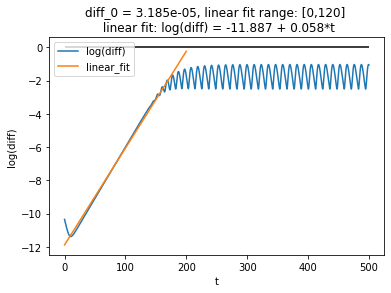

In [207]:
delta = np.linalg.norm(xt2[:,0:5] - xt1[:,0:5], axis=1)

# obtain least square beta
t = np.linspace(0,120,12001)
X = np.array([np.ones(12001), t]).T
y = np.log(delta[:12001]).T
beta_empirical = np.linalg.lstsq(X, y, rcond=None)[0]

# plot
plt.plot(np.linspace(0,500,50001), np.log(delta), label="log(diff)")
plt.plot(np.linspace(0,200,20001), beta_empirical[0] + beta_empirical[1] * np.linspace(0,200,20001), label="linear_fit")
plt.hlines([0], xmin=0, xmax=500)
plt.legend()
plt.xlabel("t")
plt.ylabel("log(diff)")
plt.title(f"diff_0 = {np.linalg.norm(x_int1-x_int2):.3e}, linear fit range: [0,120] \n linear fit: log(diff) = {beta_empirical[0]:.3f} + {beta_empirical[1]:.3f}*t")
# plt.savefig("Hypercycle_Lyapunov_Empirical")
1

Average of trajectories (Figure 5)

In [238]:
roling_avg = np.cumsum(xt1, axis=0) / (1+np.arange(xt1.shape[0]).reshape((-1,1)))

1

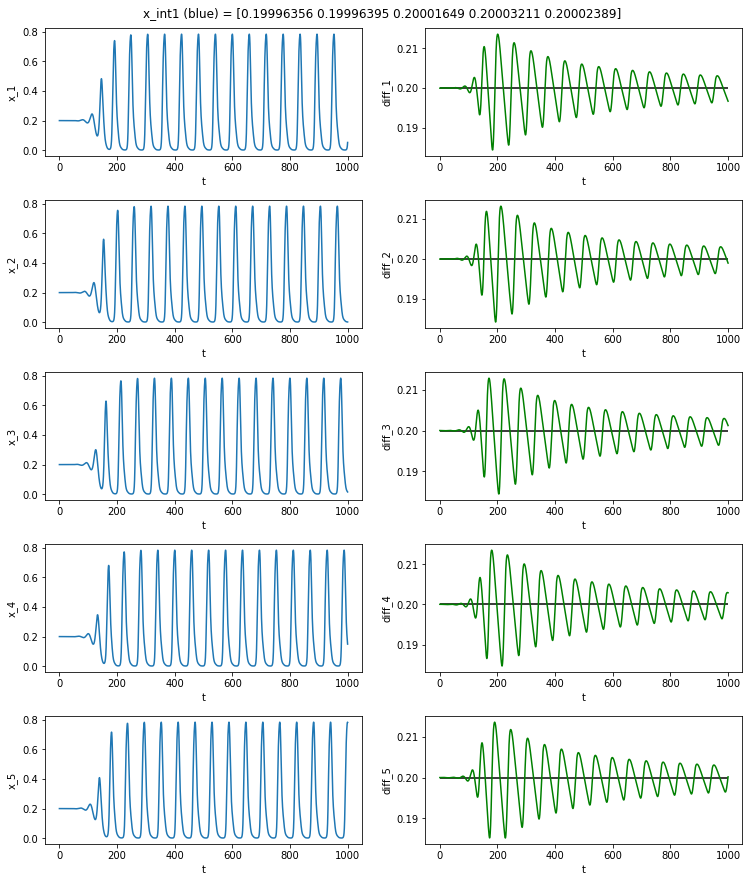

In [244]:
fig, ax = plt.subplots(5,2,figsize=(12.5,15))
for i in range(5):
    ax[i,0].plot(np.linspace(0,1000,100001), xt1[:,i])
    ax[i,0].set_ylabel(f"x_{i+1}")
    ax[i,0].set_xlabel("t")
    ax[i,1].plot(np.linspace(0,1000,100001), roling_avg[:,i], color="green")
    ax[i,1].set_ylabel(f"diff_{i+1}")
    ax[i,1].set_xlabel("t")
    ax[i,1].hlines([0.2], xmin=0, xmax=1000)

fig.subplots_adjust(hspace=0.35)
fig.suptitle(f'x_int1 (blue) = {x_int1}', y=0.9)
# plt.savefig("Hypercycle_average_to_mean")
1